# CNN

## **第一部分：CNN 训练的核心流程与要素**

训练一个神经网络的宏观步骤如下。

1. **训练循环 (Training Loop - Mini-batch SGD):**
    - **采样 (Sample):** 从数据集中抽取一小批（mini-batch）数据。
    - **前向传播 (Forward Pass):** 将数据输入网络，计算预测输出，并得到损失（Loss）。
    - **反向传播 (Backprop):** 计算损失函数关于网络参数的梯度。
    - **参数更新 (Update):** 使用计算出的梯度来更新网络的权重等参数。
2. **训练的关键组成部分 (Key Components of Training):**（本节课主要涉及此板块内容）
    - **数据准备 (Data Preparation):** 如何处理输入数据以利于训练。
    - **权重初始化 (Weight Initialization):** 如何设置网络参数的初始值。
    - **优化过程 (Optimization):**
        - **优化器 (Optimizer):** 选择何种算法来更新参数。
        - **学习率 (Learning Rate):** 控制参数更新的步长。
    - **欠拟合与过拟合 (Underfitting & Overfitting):** 诊断和解决训练中的常见问题。

---


## **第二部分：数据预处理**

目的是使数据更适合网络学习。

- **核心操作:**
    1. **零中心化 (Zero-centering):** 将输入数据减去其均值，使数据分布的中心迁移到原点。
    2. **归一化 (Normalization):** 在零中心化的基础上，再将数据除以其标准差，使得数据具有单位方差。
- **为何重要:**
    - **解决梯度更新问题:** 如果输入数据总是正数，会导致对权重的梯度要么全为正，要么全为负，使得梯度下降的路径呈“Z”字形，收敛效率低下。
    - **优化损失曲面:** 归一化后的数据使得损失对权重的变化不那么敏感，损失曲面更平滑，优化过程更简单、更稳定。
- **实践应用 (如 CIFAR-10):**
    - 对图像的每个颜色通道（R, G, B）独立地计算均值和标准差，并进行归一化处理。

### 问题一：为什么零中心化能避免“Z”字形梯度下降？

为了理解这一点，我们需要看一下反向传播中**权重梯度**的计算公式。我们以一个最简单的神经元为例，它接收一组输入 x = [x1, x2, ..., xn] 和一组权重 w = [w1, w2, ..., wn]。

神经元的计算分为两步：

1. 线性求和：s = w1*x1 + w2*x2 + ... + wn*xn + b
2. 经过激活函数：out = f(s)

现在，我们想计算损失函数 L 对某个权重 wi 的梯度 ∂L/∂wi。根据链式法则：

∂L/∂wi = (∂L/∂out) * (∂out/∂s) * (∂s/∂wi)

我们来分析这个公式的每一部分：

- ∂L/∂out：是上一层传回来的梯度，我们假设它是一个标量 δ。
- ∂out/∂s：是激活函数的导数，f'(s)。
- ∂s/∂wi：这是最关键的部分！s 对 wi 的偏导数就是 xi。

所以，最终的梯度公式是：

**∂L/∂wi = δ * f'(s) * xi**

**现在，让我们看看在输入 x “恒为正”的情况下会发生什么：**

1. **xi 总是正数：** 因为我们假设所有输入特征 xi 都是正的（比如图像像素值0-255）。
2. **δ * f'(s) 的符号是固定的：** δ 是从上一层传来的梯度，在一次反向传播中，它的符号是确定的（要么是正，要么是负）。f'(s) 通常也是正的（比如Sigmoid, ReLU的导数）。所以，δ * f'(s) 这一项，对于**同一层的所有权重**来说，它的符号是相同的。
3. **梯度同号！** 既然 ∂L/∂wi = (某个固定符号的数) * xi，而 xi 总是正的，这意味着 ∂L/∂w1, ∂L/∂w2, ..., ∂L/∂wn **所有这些梯度，要么全部为正，要么全部为负！**

**“Z”字形路线的成因：**

想象一下，你的最优权重 w_optimal 需要一部分权重增加，一部分权重减少。但由于梯度同号的限制，你的权重更新 w_new = w - lr * ∇w 只能让**所有权重同时增加**或**同时减少**。

这就像你想往东北方向走（需要向东走，也需要向北走），但你被限制了每次只能**纯向东**或**纯向北**走。为了到达东北，你只能先向东走一步，再向北走一步，形成“Z”字形的路线。这大大降低了收敛效率。

**零中心化如何解决这个问题？**

当数据经过零中心化后，输入 x = [x1, x2, ..., xn] 中，大约一半的 xi 是正数，一半是负数。

现在，梯度 ∂L/∂wi 的符号就由 xi 的符号决定了。

- 如果 xi > 0，∂L/∂wi 的符号与 δ * f'(s) 相同。
- 如果 xi < 0，∂L/∂wi 的符号与 δ * f'(s) 相反。

这样一来，**梯度的各个分量 ∂L/∂wi 就可以有正有负了**，权重更新的方向不再受限，可以更直接地朝向最优解前进，避免了“Z”字形路线。

### 问题二：归一化会不会造成数据不准确？让权重变化不那么明显的意义是什么？

**1. 归一化不是“丢失信息”，而是“解耦信息”。**

归一化操作包含两个部分：减去均值和除以标准差。

x_norm = (x - μ) / σ

这个过程是**完全可逆的**：x = x_norm * σ + μ。

Batch Normalization 层甚至做得更绝，它在归一化之后，又引入了两个可学习的参数 γ 和 β 来进行缩放和平移：

y = γ * x_norm + β

最神奇的是，如果网络发现原始分布是最好的，它可以通过学习让 γ = σ 并且 β = μ，从而**完美地恢复出原始数据**！

所以，归一化并没有“强行”让数据变得不准确。它更像是在说：“我先把你拉到一个标准的起跑线上（均值为0，方差为1），然后给你两个控制器（γ 和 β），让你自己去学一个最适合你的、新的、但更稳定的分布。”

**2. “让权重变化不那么明显”的意义：平滑损失曲面**

- **损失曲面变成一个狭长的“山谷”：** 在 w1 方向上，损失变化很平缓；但在 w2 方向上，即使 w2 发生微小的变化（比如从 1e-4 变成 2e-4），都会因为乘以一个很大的 x2 而导致输出 y 发生剧烈变化，所以损失变化非常陡峭。
- **优化困难：** 在这种狭长的地形中，梯度下降法会像我们之前讨论的那样，在陡峭的 w2 方向上来回震荡，而在平缓的 w1 方向上进展缓慢。

---



## **第三部分：权重初始化**

不恰当的初始化会直接导致网络无法学习（梯度消失或梯度爆炸）。

1. **错误尝试1：初始化为非常小的随机数**
    - **现象:** 在深层网络中，随着前向传播，神经元的激活值会迅速衰减趋近于0。
    - **后果:** **梯度消失 (Vanishing Gradients)**。反向传播时，梯度也会趋近于0，导致权重无法更新，网络学习停滞。
2. **错误尝试2：初始化为较大的随机数**
    - **现象:** 对于 `tanh` 等饱和激活函数，神经元的输出会很快饱和到-1或1。
    - **后果:** **梯度消失**。激活函数进入饱和区，其导数（梯度）为0，导致学习停滞。
3. **有效方法1：Xavier 初始化**
    - **核心思想:** 维持输入和输出的方差一致，使得激活值在各层之间保持一个合理的分布。
    - **公式:** 权重的标准差设为 `sqrt(1 / Din)`，其中 `Din` 是输入神经元的数量。
    - **适用场景:** 在 `tanh` 等以0为中心的激活函数中表现良好。
    - **局限性:** 当使用 **ReLU** 激活函数时，由于 ReLU 会将一半的激活值置为0，破坏了 Xavier 初始化的假设，导致激活值逐层减小，最终仍然可能趋向于0。
4. **有效方法2：He 初始化**
    - **核心思想:** 专门为 ReLU 激活函数设计的初始化方法。
    - **公式:** 权重的标准差设为 `sqrt(2 / Din)`。这个额外的因子2恰好弥补了 ReLU 丢弃负半轴信息所带来的方差减半问题。
    - **效果:** 即使在非常深的网络中，使用 ReLU 和 He 初始化也能保持激活值的稳定，是目前构建深度网络的标准实践。

---

## **第四部分：优化算法**

选择合适的优化器可以更快、更稳定地找到损失函数的最小值。

1. **SGD (随机梯度下降):**
    - **问题1: 高条件数问题:** 在狭长的“山谷”状损失曲面中，会在陡峭方向上震荡，而在平缓方向上进展缓慢。
    - **问题2: 局部最优/鞍点:** 容易陷入梯度为0的局部最小值或鞍点。
    - **问题3: 梯度噪声:** 由 mini-batch 带来的梯度估计存在噪声。
2. **SGD + Momentum:**
    - **改进:** 引入“速度”的概念，累积过去的梯度方向。这有助于冲出局部最优和鞍点，并抑制在陡峭方向上的震荡，加速在平缓方向上的前进。
3. **Adam (Adaptive Moment Estimation):**
    - **改进:** 结合了 Momentum 和 RMSProp 的优点。它不仅为每个参数保留了梯度的“速度”（一阶矩），还保留了梯度平方的“历史信息”（二阶矩），从而为每个参数计算自适应的学习率。
    - **优势:** 通常收敛速度更快，是目前最常用、最稳健的默认优化器之一。

---


## **第五部分：学习率**

- **选择:**
    - **过低:** 收敛速度极慢。
    - **过高:** 损失可能在最小值附近震荡甚至发散。
- **学习率调度 (Learning Rate Schedule):**
    - **思想:** 训练初期使用较大的学习率快速下降，后期使用较小的学习率精细调整。
    - **常见策略:**
        - **阶梯式衰减 (Step Decay):** 在特定的训练轮数（epoch）后，将学习率乘以一个衰减因子（如0.1），这个不是固定的，需要根据具体情况确认。
        - **余弦退火 (Cosine Schedule):** 学习率按余弦函数曲线进行平滑衰减。
        - **预热 (Warmup):** 在训练最开始的几千次迭代中，将学习率从0线性增加到一个初始值，以避免训练初期的不稳定性。

这些与显卡，数据量等有关：

**线性缩放规则” (Linear Scaling Rule)**：当 batch_size 扩大 N 倍时，初始学习率也应该扩大 N 倍，以保持训练的效率。所以，你的显卡配置直接决定了你能使用的 batch_size 上限，从而影响了你初始学习率的选择。

数据集的大小决定了一个 Epoch 的“含金量”。对于更大的数据集：

1. **衰减时机可能需要提前：** 你可能不需要训练那么多Epoch，衰减点应该设置在更少的Epoch数上（比如15、25个Epoch）。
2. **衰减策略可能需要改变：** 与其使用阶梯式（Step）的剧烈下降，不如使用更平滑的衰减方式，如**余弦退火 (Cosine Annealing)**，让学习率在漫长的Epoch中缓慢下降。

---


## **第六部分：解决欠拟合与过拟合**

这是确保模型具有良好**泛化能力**的关键。

### **A. 解决欠拟合 (模型没学好)**

欠拟合通常由模型容量不足或优化不充分导致。

#### **批量归一化 (Batch Normalization, BN):**

- **作用:**
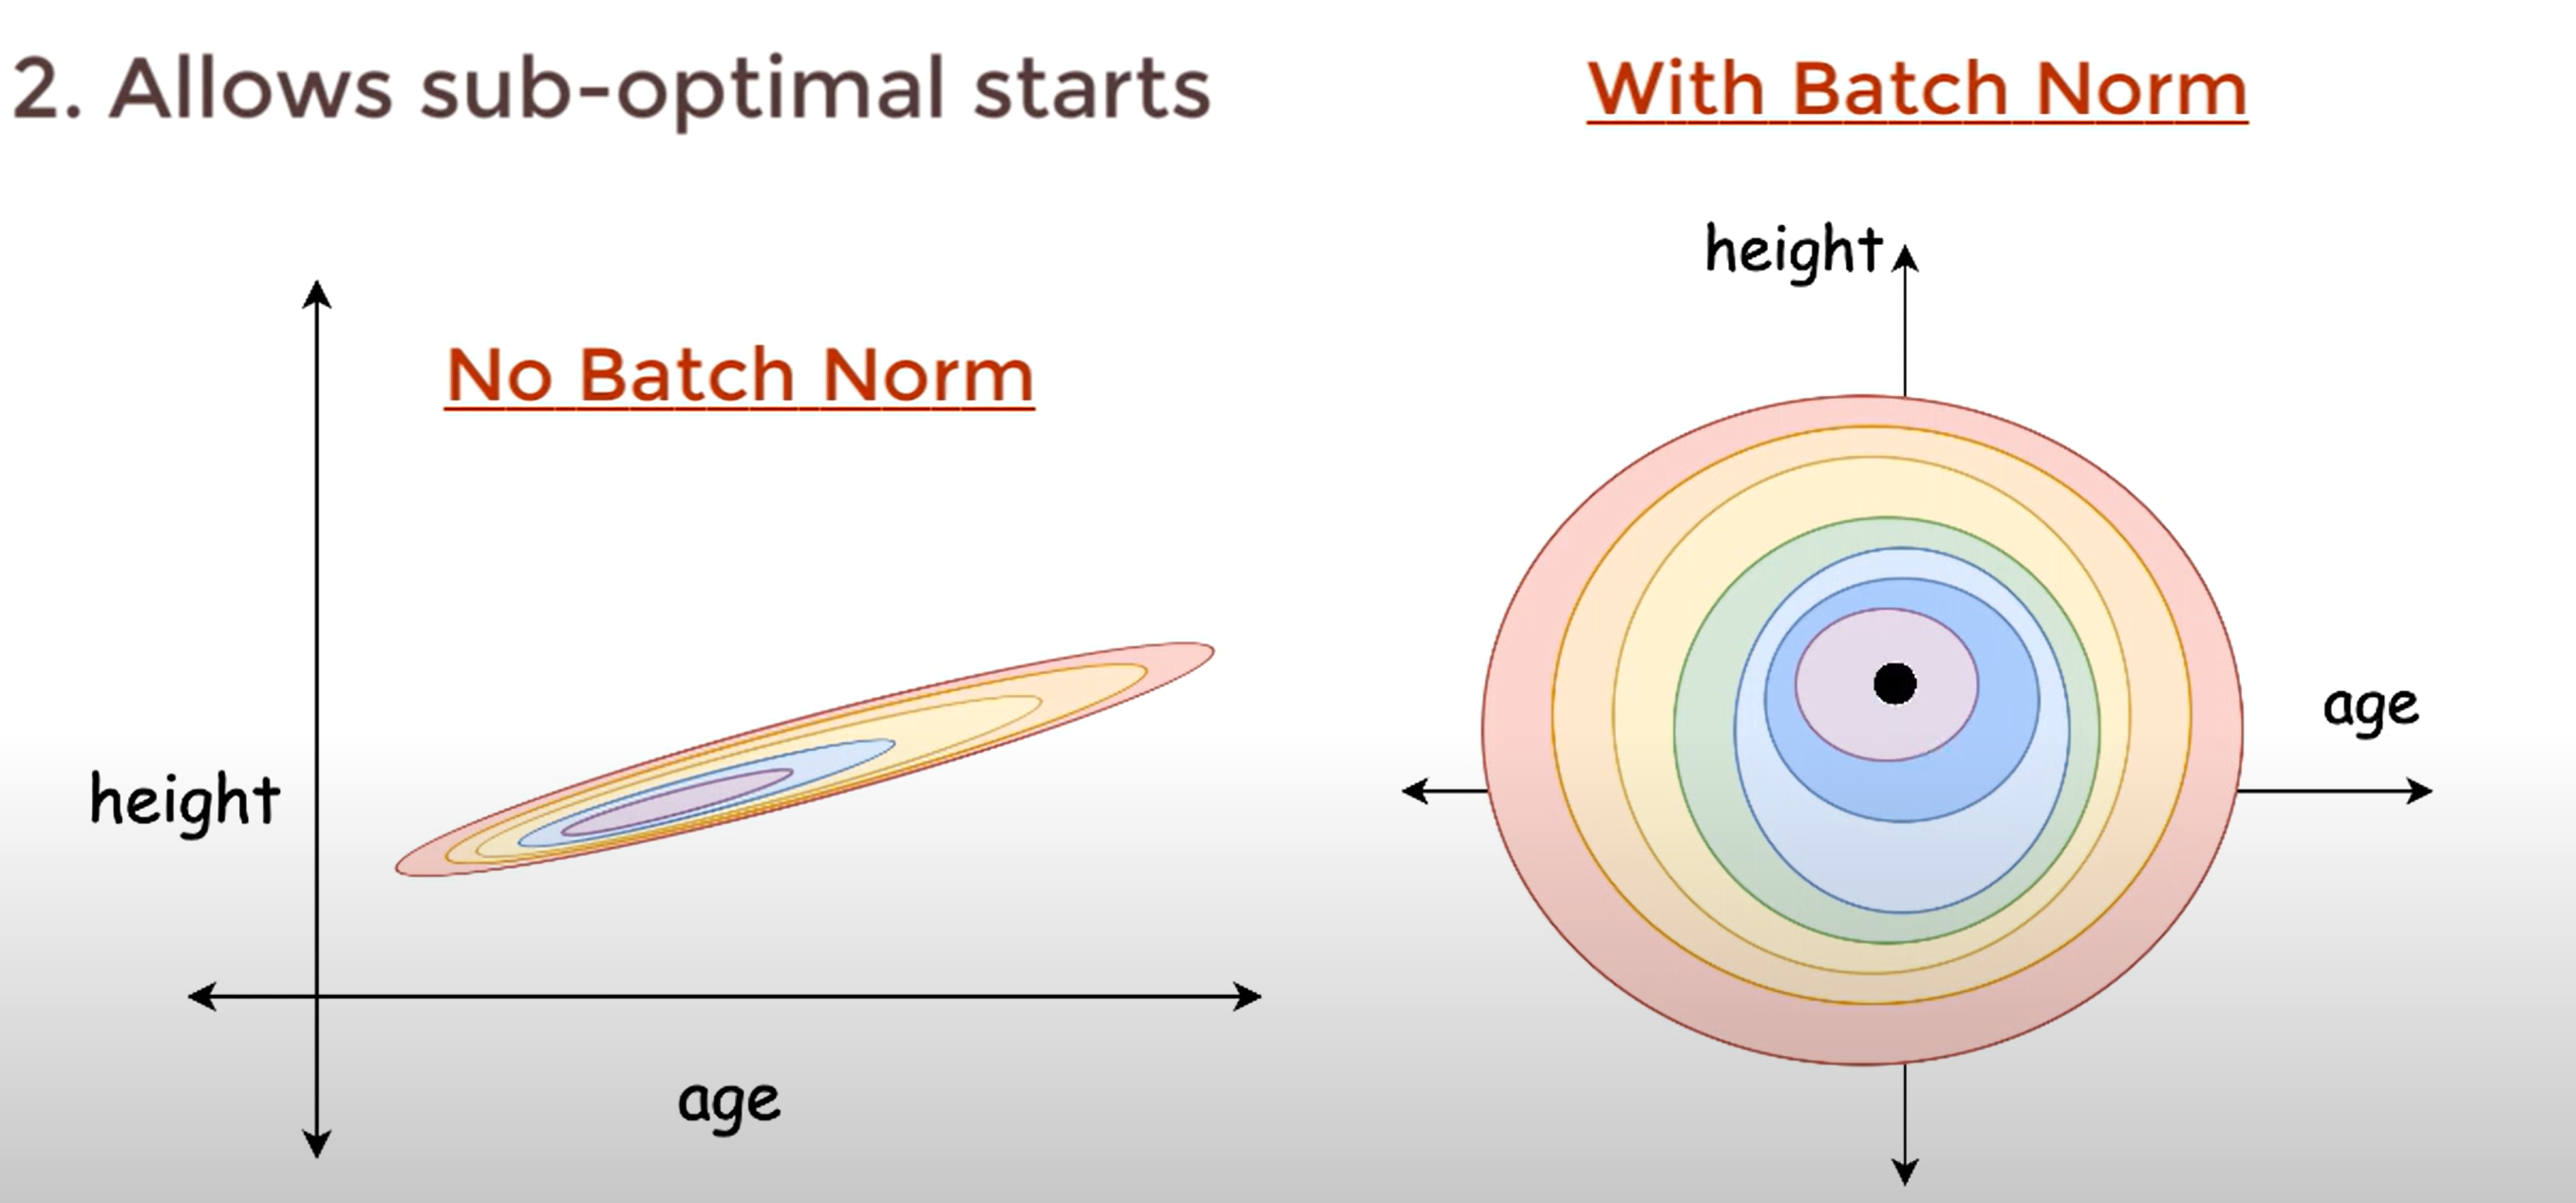

该视频介绍了why we need BN，不过具体原因还有待研究

[Batch Normalization - EXPLAINED!](https://www.youtube.com/watch?v=DtEq44FTPM4)

- **主要贡献:** 平滑损失函数的曲面，使优化过程更简单，允许使用更高的学习率，加速收敛。
- **其他优点:** 改善梯度流，降低对初始化的敏感度，并带有一定的正则化效果。
- **问题:** 依赖批次大小（batch size），在批次很小时效果会变差。
- **替代方案:** **组归一化 (Group Normalization)** 等不依赖批次大小的技术。

##### 问题三：BN和weight initialization的区别

**比喻：一场盛大的多米诺骨牌表演**

- **你的神经网络：** 是一长串需要被推倒的多米诺骨牌。
- **训练成功：** 意味着第一块骨牌倒下后，能顺利地、漂亮地把所有骨牌都撞倒。
- **骨牌之间的传递：** 就像是网络中，前一层的输出（激活值）作为后一层的输入。
- **激活值的分布：** 就像是骨牌的间距和姿态。太近了会卡住，太远了撞不上，歪了会倒向错误的方向。

---

**1. Weight Initialization (权重初始化)：摆好第一块骨牌**

- **它是什么？** 在你开始推第一块骨牌之前，你必须**精心设计和摆放好所有骨牌的初始位置**。
- **它的作用：** 使用Xavier或He初始化，就像是你有了一个精确的尺子和量角器。你确保了每块骨牌的初始间距和角度都是完美的，理论上只要轻轻一推，整个序列就能顺利倒下。
- **它解决了什么问题？** 它解决了“还没开始就失败了”的问题。如果你随便乱摆（随机初始化不当），可能第一块骨牌连第二块都撞不到（梯度消失），或者第一块用力过猛把后面一大片都砸烂了（梯度爆炸）。

**所以，Weight Initialization 就像是表演开始前的“初始布局”。它只负责在第0秒钟，让所有骨牌都处于一个“理论上完美”的待命状态。**

---

**2. 训练过程中的“大问题”：骨牌会自己动！**

现在，你推倒了第一块骨牌，表演开始了！也就是，你的网络开始训练了。

- **反向传播和权重更新：** 在训练中，网络会根据误差来调整权重。这就像是**每一块骨牌在倒下的过程中，都会微微地移动和调整自己的位置，以便下一次能倒得更好**。
- **问题来了：**
    - 第10块骨牌为了调整自己，稍微向左偏了一点。
    - 这导致第11块骨牌接收到的冲击不再是“初始布局”时那么完美了。
    - 为了适应这个变化，第11块骨牌也得调整自己的位置。
    - 这个变化会像涟漪一样向后传递，越往后的骨牌，面对的“输入冲击”就越混乱、越不可预测。

你的初始布局（Weight Initialization）再完美，也无法控制骨牌们在“学习”过程中自己发生的位置变化。这种“内部环境的持续动态变化”，就是我们之前提到的**内部协变量偏移 (Internal Covariate Shift)**。

---

**3. Batch Normalization：在每块骨牌前放一个“校准器”**

面对这种混乱，我们该怎么办呢？Batch Normalization (BN) 就是那个天才的解决方案。

- **它是什么？** 它不是在表演前做一次性的布局。而是在**每一对骨牌之间**，都安插了一个**自动校准机器人**。
- **它的作用：**
    - 第10块骨牌，不管它最终以多么奇怪的角度和力量倒下来...
    - ...这个校准机器人（BN层）会先“接住”这个冲击，然后**把它重新校准成一个标准的、完美的冲击力**，再传递给第11块骨牌。
- **它解决了什么问题？** 它解决了训练过程中内部环境剧烈变化的问题。有了BN，每一块骨牌（每一层网络）都不再需要去适应前一块骨牌的混乱变化，因为它们接收到的永远是BN层“格式化”过的、稳定的、标准的输入。

---

**4. 问题与理解：BN和WI在操作上是一样的，但是操作对象是不同的，WI是对初始的权重做调整，BN是对每次输入的数据做调整？**

你的理解可以精炼为：

- **WI（权重初始化）：** 在训练**开始前**，对**权重 (W)** 进行**一次性**的合理设置。
- **BN（批量归一化）：** 在训练**过程中**，对每一层的**输入/激活值 (x)** 进行**持续**的标准化调整。

它们的目标都是为了**维持数据流的稳定**，防止信号（无论是前向的激活值还是反向的梯度）过大或过小。但实现这个目标的“操作”和“时机”是完全不同的。

让我们来精确对比一下它们的“操作”：

**Weight Initialization (WI) 的“操作”**

- **操作公式（以He初始化为例）：** `W = np.random.randn(shape) * sqrt(2 / fan_in)`
- **操作内容：** 从一个标准正态分布中随机采样，然后乘以一个特定的缩放因子 (`sqrt(2 / fan_in)`)。
- **操作本质：** 这是一个**缩放操作**。它通过精心设计的缩放，让权重矩阵在乘以输入后，输出的方差能保持稳定。
- **操作时机：** 仅在创建模型的那一刻执行一次。

**Batch Normalization (BN) 的“操作”**

- **操作公式（训练时）：** `y = γ * (x - μ_batch) / sqrt(σ²_batch + ε) + β`
- **操作内容：**
    1. 计算**当前批次数据**的均值 `μ_batch` 和方差 `σ²_batch`。
    2. 用这个均值和方差对数据 `x` 进行**中心化和缩放**（标准化）。
    3. 再用两个可学习的参数 `γ` 和 `β` 对标准化后的数据进行**线性变换**。
- **操作本质：** 这是一个**动态的、数据驱动的标准化+仿射变换**。它的参数（μ 和 σ）是根据流经它的数据实时计算的。
- **操作时机：** 在每一次前向传播中都会执行。

---

**精确的总结**

所以，一个更精确的说法是：

**BN 和 WI 的目标相似（维持数据稳定），作用对象不同（激活值 vs. 权重），但它们底层的操作和机制是完全不同的。**

- **WI 是一种静态的、基于理论推导的权重缩放策略，是一次性的“冷启动”设置。**
- **BN 是一种动态的、基于当前数据统计的实时标准化流程，是持续性的“热校准”机制。**

**总结与区别**

| 特性 | Weight Initialization (权重初始化) | Batch Normalization (批量归一化) |
| --- | --- | --- |
| **作用时机** | **仅在训练开始前，一次性** | **在训练的每一次前向传播中，持续作用** |
| **作用对象** | 网络的**权重 (W)** | 层的**输出/激活值 (Activations)** |
| **工作方式** | 静态的规则，用于设置初始值 | 动态的计算，持续校准数据分布 |
| **解决的问题** | 保证训练能**顺利启动**，避免初始梯度消失/爆炸 | 保证训练过程**持续稳定**，对抗内部协变量偏移，加速收敛 |
| **比喻** | **表演前的初始布局** | **表演过程中，每一步的实时校准** |

**所以，它们根本不是互相替代的关系，而是相辅相成的黄金搭档！**

你需要一个好的 **Weight Initialization** 来确保你的“多米诺表演”有一个好的开端。
然后，你需要在整个过程中持续使用 **Batch Normalization**，来确保这场表演不会因为内部的动态调整而中途崩盘。

---

##### 问题四：BN为什么会使得训练和评估表现出现差异？

**1. "Dependence on the batch dimension" (对批次维度的依赖)**

- 假设你的数据张量维度是 `(N, C, H, W)`:
    - `N`: 批次大小 (Batch Size)
    - `C`: 通道数 (Channels)
    - `H, W`: 高度和宽度
- BN在计算第 `c` 个通道的均值时，会把**N个样本**在第 `c` 个通道上的**所有像素值 (H*W)** 全部加起来求平均。这个计算**离不开 N**。如果N变了，计算出的均值和方差就会变。这就是“对批次维度的依赖”。

**2. "Discrepancy between train and eval modes" (训练和评估模式的差异)**

- **这个差异是什么？** 正是因为BN依赖批次，才导致了它必须有两种工作模式：
    - **训练模式 (Train Mode):** 我们有批次（比如N=32），所以可以愉快地计算当前批次的均值和方差，并用它们来做归一化。
    - **评估模式 (Eval Mode):** 我们通常只对**单个样本**（N=1）进行预测。这时，我们无法计算“批次”的均值和方差（只有一个样本，统计量无意义）。所以，BN必须换一种方法：使用在整个训练过程中通过滑动平均**预先计算并存储好**的全局均值和方差。
- **这个差异是问题的根源：** 训练时的归一化是**动态的、数据相关的**，而评估时的归一化是**静态的、预先算好的**。这两种计算方式的微小差异，以及对批次大小的敏感性，可能会导致一些问题（比如，训练时效果很好，一到评估时性能就下降）。

**“我们能否去掉（Normalization）对批次维度的依赖呢？（如果我们能做到），那么我们就不再需要区分训练和评估两种模式了。”**

![image 3.png](<attachment:image 3.png>)

#### 残差/跳跃连接 (Residual/Skip Links, 如 ResNet):
*   **问题背景:** 理论上更深的网络性能应该更好，但实践中“普通”的深层网络反而出现性能退化（训练误差和测试误差都更高），这是一个**优化问题**。
*   **解决方案:** 引入 `H(x) = F(x) + x` 结构。网络不再直接学习目标映射 `H(x)`，而是学习残差 `F(x)`。即深层网络最差也学一个和底层相同的结果，保证了层数越多，效果越好。
*   **作用:**
    *   为梯度反向传播提供了“高速公路”，有效解决了深度网络中的梯度消失问题。
    *   极大地平滑了损失曲面，使非常深的网络（上百甚至上千层）变得可以训练。

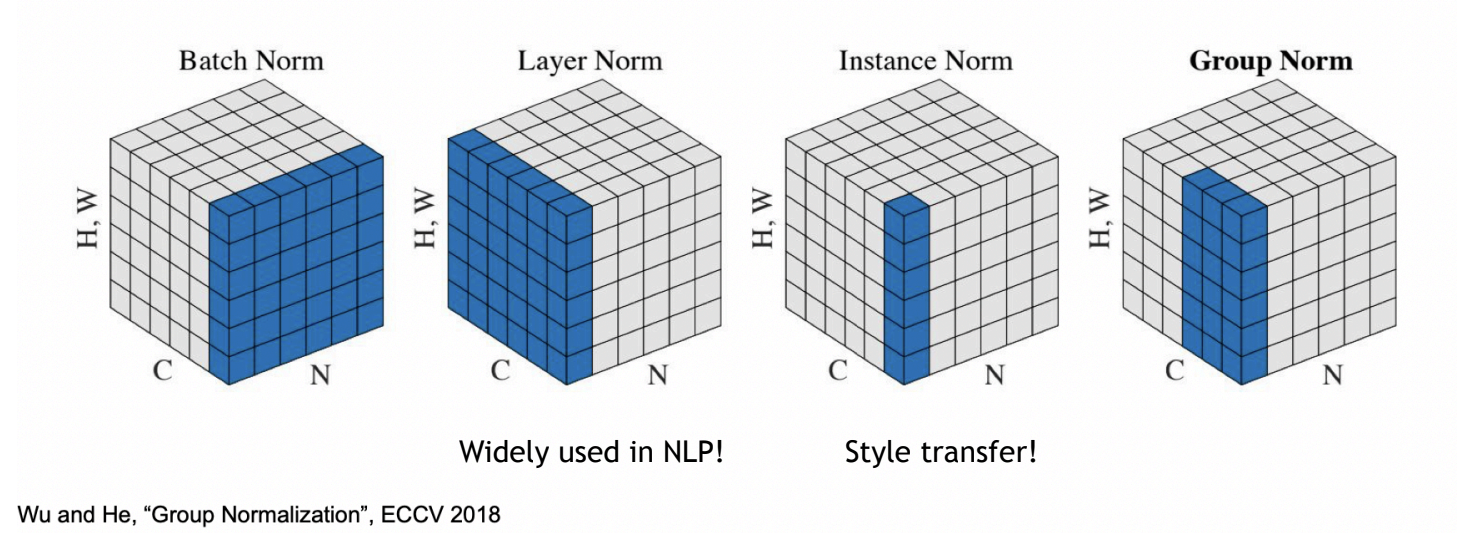
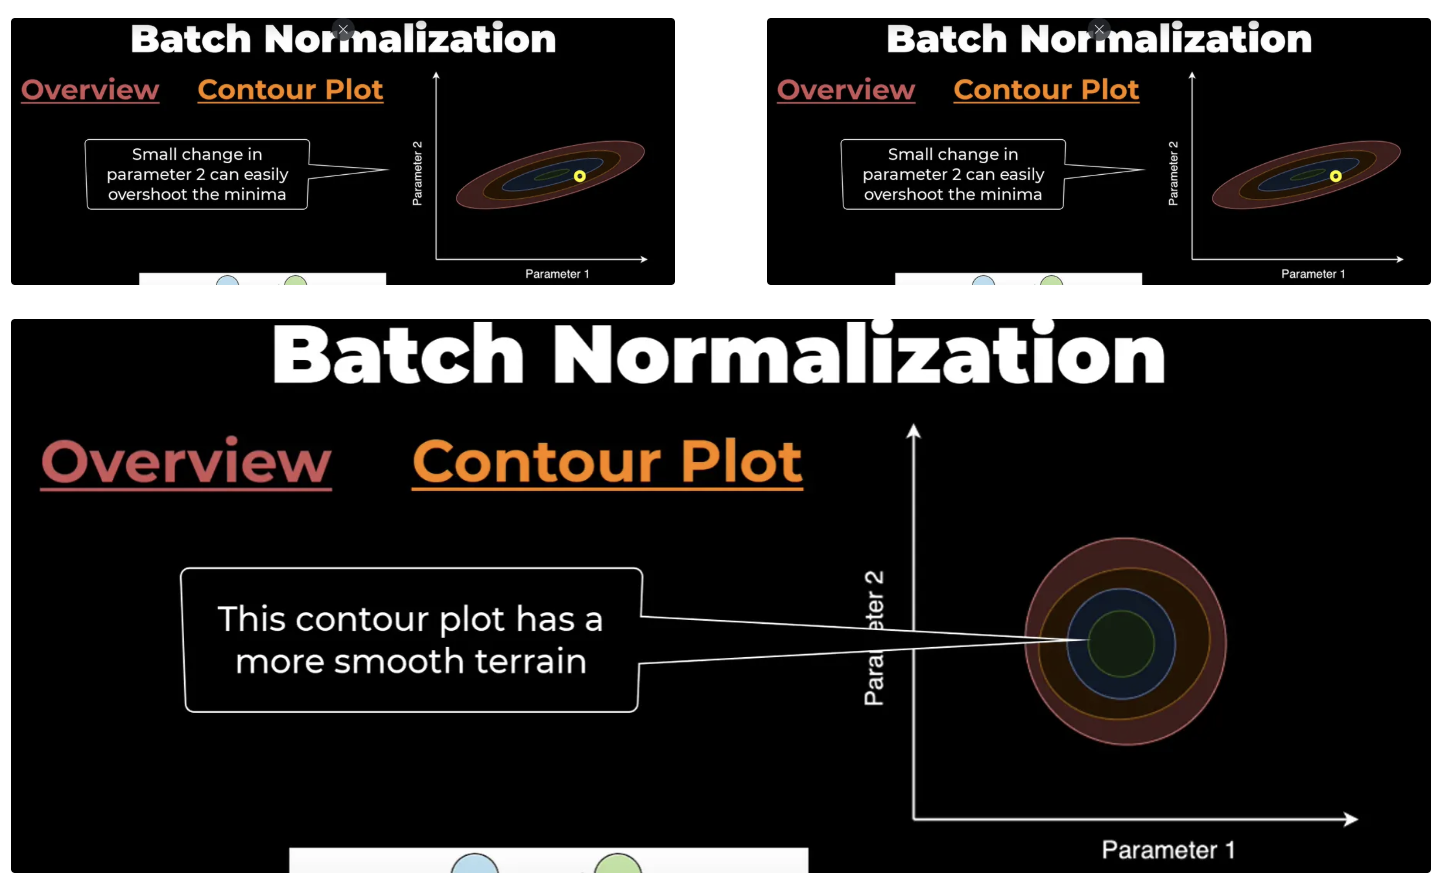


### B. 解决过拟合 (模型在训练集上学的“太好”了)

过拟合指模型过度拟合了训练数据的噪声和细节，导致在未见过的数据上表现不佳。核心思想是**平衡数据多样性与模型复杂度**。

1.  **从数据视角出发:**
    *   **数据增强 (Data Augmentation):** 通过对现有数据进行旋转、翻转、裁剪、颜色抖动等变换，无成本地创造出更多样的训练样本。这是最有效、最常用的防止过拟合的方法之一。
    *   注意一定要在augment之后肉眼过一下数据集，避免出现augment成不可识别的物体了

2.  **从模型视角出发:**
    *   **正则化 (Regularization):**
        *   **核心思想:** 在损失函数中加入一个惩罚项，限制模型权重的大小，从而限制模型的复杂度（奥卡姆剃刀原理）。
        *   **常见类型:** L2 正则化（权重衰减）、L1 正则化。
        *   **建议**：一开始先不加，等main loss下降的差不多了，如果有overfit再调。
    *   **Dropout:**
        *   **操作:** 在训练过程中，以一定概率随机地“丢弃”（即置零）一部分神经元的输出。
        *   **作用:**
            *   强迫网络学习到更鲁棒、更冗余的特征，因为不能依赖于任何一个特定的神经元。
            *   可以看作是一种模型集成，每次迭代都在训练一个不同的“子网络”。
    *   **提前终止 (Early Stopping):** 监控模型在验证集上的性能，当性能不再提升甚至开始下降时，就停止训练。

## 第七部分：CNN应用之图像分类
### SoftMax 分类器 与 交叉熵损失 

我们可以将这个组合的整个工作流程拆解为三个环环相扣的步骤：

1.  **从模型原始输出到分数（Logits）**
2.  **从分数到概率（SoftMax Function）**
3.  **从概率到损失（Cross-Entropy Loss）**

---

#### **步骤一：模型的原始输出 (Raw Scores / Logits)**

首先，一个用于分类的卷积神经网络（CNN）在接收一张输入图像后，经过一系列的卷积、激活函数和池化层，最后通常会通过一个或多个全连接层（Fully Connected Layers）。这个网络的最后一层会为每一个类别输出一个原始的、未经处理的数值。

*   **这些数值叫什么？** 它们通常被称为 **“分数 (scores)”** 或 **“logits”**。
*   **它们的特征是什么？** 这些分数可以是任何实数，可正可负，可大可小，它们的和也不具备任何特定意义。我们需要一种方法，将这些任意的分数转换成符合我们直觉的、标准化的**概率**。

---

#### **步骤二：从分数到概率 (The SoftMax Function)**

SoftMax 函数的作用就是将步骤一中得到的 Logits 向量，转换成一个**概率分布**。

**转换过程分为两步：**

1.  **取指数 (Exponentiation)**：将所有的 Logits $s_i$ 作为 $e$ 的指数（$e^{s_i}$）。
    *   **目的**：这一步有两个关键作用。首先，$e$ 的指数函数值域为正数，这确保了转换后的“概率”都是**非负的**。其次，它会**放大**原始分数之间的差距，使得分数越高的类别，其指数值会不成比例地变得更大，强化了模型的“信心”。

2.  **归一化 (Normalization)**：将上一步得到的每个指数值，除以所有指数值的总和。
    *   **目的**：这一步确保了所有类别的输出值**相加等于 1**。
    *   现在，这个输出向量完全符合概率分布的定义：每个值都在 $[0, 1]$ 区间内，且所有值的总和为 1。

**数学公式总结：**  
对于第 $i$ 个类别的概率 $P_i$，其计算公式为：

$$
P_i = \frac{e^{s_i}}{\sum_j e^{s_j}}
$$

其中 $s_i$ 是第 $i$ 个类别的原始分数（logit），$j$ 遍历所有类别。

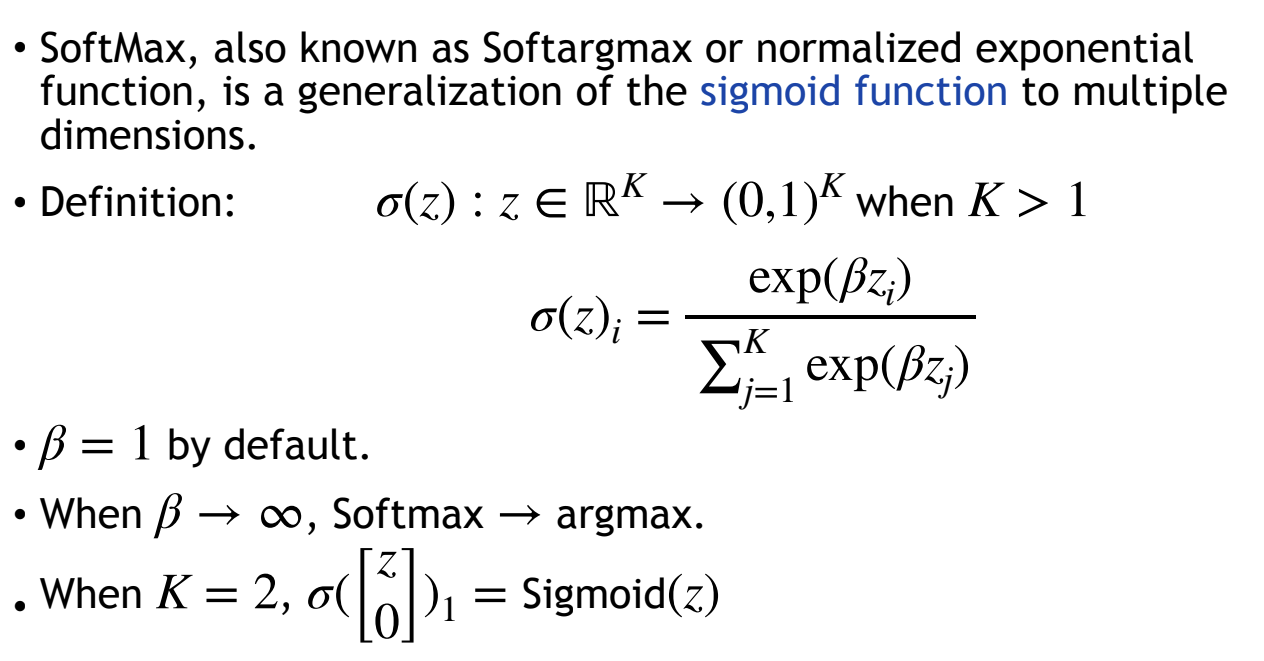

β的大小决定了logits之间差异体现在概率中的差异大小，一般不会选取很大的β，避免gradient趋近于0。

---

#### **步骤三：从概率到损失 (The Cross-Entropy Loss)**

现在模型给出了一个预测的概率分布 `[0.84, 0.15, 0.01]`，我们需要一个**损失函数**来衡量这个预测与**真实情况**之间的差距。这个差距就是我们常说的**“损失 (Loss)”**。

**1. 准备真实标签 (Ground Truth)**  
首先，我们需要将真实的标签表示成和模型输出一样的概率分布形式。在分类任务中，这通常通过 **“独热编码 (One-Hot Encoding)”** 来实现。  
*   因为我们知道输入的图片**就是**一只猫，所以其真实的概率分布是 100% 的猫，0% 的其他。

**2. 计算交叉熵 (Calculating Cross-Entropy)**  
交叉熵源于信息论，是用来衡量两个概率分布之间差异的指标。其核心思想是：**用一个我们“预测”的概率分布，来表示一个“真实”的概率分布，需要付出多少“代价”**。

**简化后的直观理解：**  
交叉熵的完整公式为：

$$
L = - \sum_i y_i \log(p_i)
$$

其中 $y_i$ 是真实标签的概率（独热编码后，仅正确类别为 1，其余为 0），$p_i$ 是模型预测的概率。

**这个公式的精髓在于：**  
**交叉熵损失最终只关心模型为“正确类别”所分配的概率的负对数。**

**为什么这个损失函数是有效的？**
*   **如果模型预测正确且非常自信**：比如预测正确类别的概率为 $0.99$，损失为 $-\log(0.99) \approx 0.01$，这是一个非常小的损失值。
*   **如果模型预测正确但不太自信**：比如预测正确类别的概率为 $0.5$，损失为 $-\log(0.5) \approx 0.69$，损失值变大。
*   **如果模型预测错误且非常自信**：比如为正确类别分配了 $0.01$ 的概率，损失为 $-\log(0.01) \approx 4.6$，这是一个巨大的损失值。

这个特性使得损失函数能够极大地**惩罚**那些**“既错误又自信”**的预测，从而驱动模型在训练过程中（通过反向传播和梯度下降）调整其权重，**目标只有一个：不断提高正确类别的预测概率**。

整个流程优雅地将一个复杂的分类问题，转化为了一个清晰的优化目标：**“调整网络参数，使得正确类别的 SoftMax 输出概率尽可能接近 1”**。

## 第八部分：CNN 架构总结
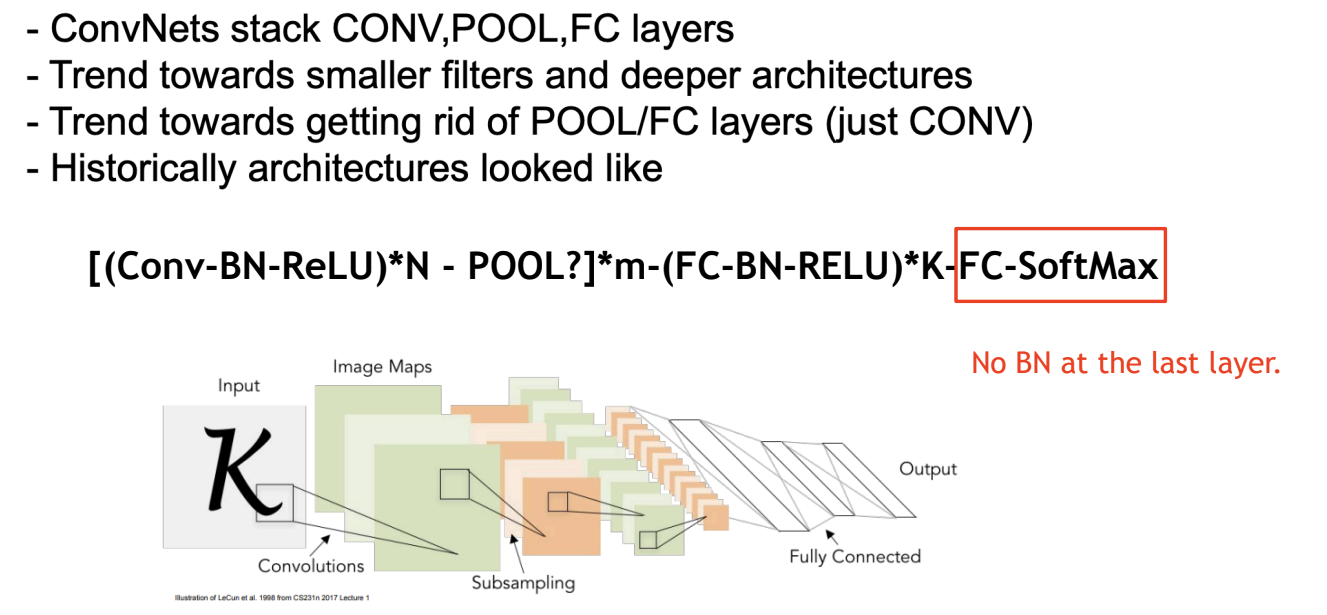

### **一、 核心构成与演进趋势**

1.  **基本构成**:
    *   一个典型的卷积神经网络（ConvNet）由三种核心层堆叠而成：
        *   **卷积层 (CONV)**
        *   **池化层 (POOL)**
        *   **全连接层 (FC)**

2.  **两大演进趋势**:
    *   **趋势 1: 更小卷积核与更深网络**
        *   现代网络倾向于使用更小的卷积核（如 3x3），并通过堆叠更多层来构建更深、更强大的网络。
    *   **趋势 2: 减少甚至移除池化/全连接层**
        *   倾向于使用带步长（stride）的卷积层来替代池化层进行下采样。
        *   倾向于使用全局平均池化（Global Average Pooling）等技术替代参数量巨大的全连接层，以减少过拟合风险。

---

### **二、 通用架构模板**

一个现代CNN的通用架构可以概括为以下公式：

**`[(Conv-BN-ReLU)*N - POOL?]*m - (FC-BN-RELU)*K - FC-SoftMax`**

这个模板可以分为两个主要部分：**特征提取器**和**分类器**。

**1. 特征提取器 (Feature Extractor)**

*   **公式部分**: `[(Conv-BN-ReLU)*N - POOL?]*m`
*   **作用**: 从原始图像中逐层提取从低级到高级的视觉特征。
*   **组件解析**:
    *   **`Conv-BN-ReLU`**: 这是现代CNN中最基础的构建模块，被称为“三件套”。
        *   **`Conv`**: 卷积层，用于提取特征。
        *   **`BN`**: 批量归一化 (Batch Normalization)，用于稳定和加速训练。
        *   **`ReLU`**: 激活函数，引入非线性。
    *   **`*N`**: 表示将 `Conv-BN-ReLU` 模块**重复 N 次**，以在同一特征图尺寸下提取更丰富的特征。
    *   **`POOL?`**: 可选的池化层（通常是最大池化），用于**下采样**，缩小特征图尺寸并减少计算量。问号表示其可能被步长>1的卷积层替代。
    *   **`*m`**: 表示将整个 `[...]` 结构块**重复 m 次**。网络通过重复这些阶段来构建深度，每个阶段通常会使特征图的通道数增加，尺寸减小。

**2. 分类器 (Classifier)**

*   **公式部分**: `(FC-BN-RELU)*K - FC-SoftMax`
*   **作用**: 将提取出的高级特征映射到最终的类别预测上。
*   **组件解析**:
    *   **`(FC-BN-RELU)*K`**: 表示**K个隐藏的全连接层**。
        *   **`FC`**: 全连接层，用于整合全局特征信息。
    *   **`FC-SoftMax`**: 最终的**输出层**。
        *   **`FC`**: 输出层的神经元数量等于类别总数，其输出为原始分数（logits）。
        *   **`SoftMax`**: 将原始分数转换为最终的类别概率分布。

---

### **三、 重要实践注记**

*   **最后一层不使用批量归一化 (No BN at the last layer)**
    *   **原因**: 最后一层全连接层的输出（logits）将直接送入 SoftMax 函数。SoftMax 本身就是一个归一化操作，它依赖于 logits 的相对大小。在此之前使用 BN 会限制 logits 的范围，没有必要且可能影响性能。